In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import datetime
import xarray
import glob
from scipy import signal
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import waipy
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12) # Large figures
pylab.rcParams['image.cmap'] = 'seismic'
dpi=200;

Populating the interactive namespace from numpy and matplotlib


In [2]:
### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'32', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28)

In [3]:
mesh = xarray.open_dataset('/lcrc/group/e3sm/public_html/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.200908.nc')

In [4]:
lat = mesh.latCell.values*180/np.pi
lon = mesh.lonCell.values*180/np.pi

In [5]:
flist = sorted(glob.glob('/lcrc/group/e3sm/ac.vanroekel/hist1/hi*1.nc'))
#flist = sorted(glob.glob('/lcrc/group/e3sm/ac.vanroekel/hist1/pi*1.nc'))

In [6]:
flist

['/lcrc/group/e3sm/ac.vanroekel/hist1/hist11.nc',
 '/lcrc/group/e3sm/ac.vanroekel/hist1/hist21.nc',
 '/lcrc/group/e3sm/ac.vanroekel/hist1/hist31.nc',
 '/lcrc/group/e3sm/ac.vanroekel/hist1/hist41.nc',
 '/lcrc/group/e3sm/ac.vanroekel/hist1/hist51.nc']

In [7]:
maxP=[]
minP=[]
meanP=[]

inds=np.where(lon<0)[0]
lon[inds]+=360
loninds=np.where((lon>=170)&(lon<=240)&(lat>=-5)&(lat<=5))[0]

In [8]:
dt = 1/12.
pad = 1      # pad the time series with zeroes (recommended)
dj = 0.25    # this will do 4 sub-octaves per octave
s0 = 2.*dt    # this says start at a scale of 6 months
j1 = 7./dj    # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'Morlet'

In [9]:
def create_enso_mpas(sst,mesh,inds):
    
    sst2=sst[:,loninds]
    nt=sst.shape[0]
    area=mesh.areaCell[inds].values
    nino34=np.zeros(nt)
    for i in range(nt):
        nino34[i]=np.sum(area*sst2[i,:])/np.sum(area)
        
    #form annual cycle
    nino34a2=np.zeros_like(nino34)
    ntimes = len(nino34)
    nyrs = int(ntimes/12)
    avg = np.zeros(12)
    for j in range(12):
        avg[j] = nino34[j::12].mean()
    avgF = np.tile(avg,nyrs)

    temp = nino34[:] - avgF

    #five month avg 
    for j in range(2,ntimes-2):
        nino34a2[j] = np.mean(temp[j-2:j+2])

    nino = nino34a2 - np.mean(nino34a2)  
    return nino

In [10]:
pad = 1         # pad the time series with zeroes (recommended)
dj = 0.125       # this will do 4 sub-octaves per octave
s0 = 6*dt       # this says start at a scale of 6 months if dt =annual
j1 = 7/dj       # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72     # lag-1 autocorrelation for red noise background
param = 6
mother = 'Morlet'
dt = 1/12.

In [11]:
global_ws = []
signif=[]
for i in range(len(flist)):
    ds = xarray.open_dataset(flist[i])
    sst = ds.timeMonthly_avg_activeTracers_temperature[:,:,0].values
    ds.close()
    nino1 = create_enso_mpas(sst,mesh,loninds)
    nino_norm = waipy.normalize(nino1)
    result = waipy.cwt(nino_norm, dt, pad, dj, s0, j1, lag1, param, mother='Morlet',name='Nino34');
    global_ws.append(result['global_ws'])
    
    scale=result['scale']
    n = len(nino_norm)
    varianceV = np.var(nino_norm)
    dof = [n - s for s in scale]

    global_signif, fft_theor = waipy.wave_signif(
        varianceV, dt, scale, 1, lag1, 0.9, dof, mother, param)
    signif.append(global_signif)
    maskT = np.zeros_like(result['global_ws'])
    inds = np.where(result['global_ws']>global_signif)[0]
    maskT[inds] = 1
   # global_ws[-1] *= maskT

Nr of Scales: 66
scales [0.5, 0.5452538663326288, 0.5946035575013605, 0.6484197773255048, 0.7071067811865476, 0.7711054127039704, 0.8408964152537145, 0.9170040432046712, 1.0, 1.0905077326652577, 1.189207115002721, 1.2968395546510096, 1.4142135623730951, 1.5422108254079407, 1.681792830507429, 1.8340080864093424, 2.0, 2.1810154653305154, 2.378414230005442, 2.5936791093020193, 2.8284271247461903, 3.0844216508158815, 3.363585661014858, 3.668016172818685, 4.0, 4.362030930661031, 4.756828460010884, 5.187358218604039, 5.656854249492381, 6.168843301631763, 6.727171322029716, 7.33603234563737, 8.0, 8.724061861322062, 9.513656920021768, 10.374716437208077, 11.313708498984761, 12.337686603263526, 13.454342644059432, 14.67206469127474, 16.0, 17.448123722644123, 19.027313840043536, 20.749432874416154, 22.627416997969522, 24.675373206527052, 26.908685288118864, 29.34412938254948, 32.0, 34.896247445288246, 38.05462768008707, 41.49886574883231, 45.254833995939045, 49.350746413054104, 53.81737057623773

In [12]:
globalWS = np.asarray(global_ws)
globalWS.shape

signifF = np.asarray(signif)

In [13]:
piGlobWS = np.copy(globalWS)
pisig = np.copy(signifF)
piPeriod = result['period']

NameError: name 'resultObs' is not defined

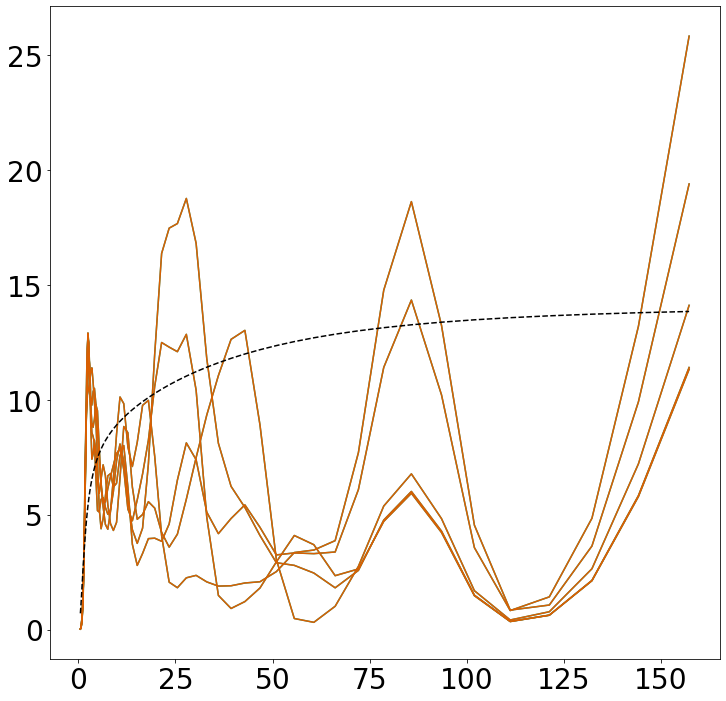

In [14]:
plt.plot(piPeriod,piGlobWS[0,:],'#1b9e77')
plt.plot(piPeriod,piGlobWS[1,:],'#1b9e77')
plt.plot(piPeriod,piGlobWS[2,:],'#1b9e77')
plt.plot(piPeriod,piGlobWS[3,:],'#1b9e77')
plt.plot(piPeriod,piGlobWS[4,:],'#1b9e77')

plt.plot(result['period'],globalWS[0,:],'#d95f02')
plt.plot(result['period'],globalWS[1,:],'#d95f02')
plt.plot(result['period'],globalWS[2,:],'#d95f02')
plt.plot(result['period'],globalWS[3,:],'#d95f02')
plt.plot(result['period'],globalWS[4,:],'#d95f02')
plt.plot(result['period'],signifF[0,:],'--k')

plt.plot(resultObs['period'],resultObs['global_ws'],'k',linewidth=3)
#plt.fill_between(result['period'],globalWS.min(axis=0),globalWS.max(axis=0),alpha=0.25,color='r')
plt.xlim(1,10)
plt.ylim(0,20)
plt.xlabel('Period (Years)',fontsize=32)
plt.ylabel(r'Power ($^o$C$^2$)',fontsize=32)
fig.tight_layout()
plt.savefig('/home/ac.vanroekel/wavelet_v1.png')

In [15]:
nino_norm = waipy.normalize(nino1)

In [16]:
time = np.linspace(1./12.,len(nino_norm)/12.,len(nino_norm))

In [18]:
scale=result['scale']
n = len(nino_norm)
varianceV = np.var(nino_norm)
dof = [n - s for s in scale]

global_signif, fft_theor = waipy.wave_signif(
    varianceV, dt, scale, 1, lag1, 0.9, dof, mother, param)

In [21]:
result['power'].shape

(40, 1980)

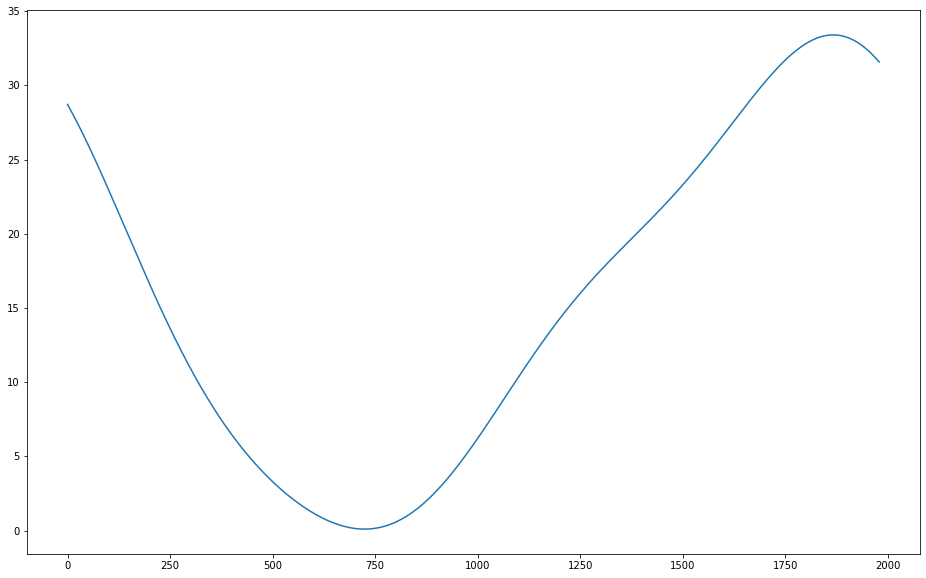

In [26]:
plt.plot(result['power'][30,:])
plt.

In [1]:
plt.plot(result['period'],result['global_ws'])
plt.plot(result['period'],result['global_signif'])
plt.plot(result['period'],global_signif
        )
plt.xlim(0,10)

NameError: name 'plt' is not defined

In [18]:
for i in range(1,len(flist)):
    pi1 = xarray.open_dataset(flist[i])
    sst = pi1.timeMonthly_avg_activeTracers_temperature[:,:,0].values
    pi1.close()
    
    sst2=sst[:,loninds]
    nt=sst.shape[0]
    area=mesh.areaCell[loninds].values
    nino34=np.zeros(nt)
    for i in range(nt):
        nino34[i]=np.sum(area*sst2[i,:])/np.sum(area)
        
    #form annual cycle
    nino34a2=np.zeros_like(nino34)
    ntimes = len(nino34)
    nyrs = int(ntimes/12)
    avg = np.zeros(12)
    for j in range(12):
        avg[j] = nino34[j::12].mean()
    avgF = np.tile(avg,nyrs)

    temp = nino34[:] - avgF

    #five month avg 
    for j in range(2,ntimes-2):
        nino34a2[j] = np.mean(temp[j-2:j+2])

    nino = nino34a2 - np.mean(nino34a2)
    time = np.arange(len(nino34a2))*dt
    varianceV = np.std(nino)**2
    meanV=np.mean(nino)
    data = (nino - meanV)/np.sqrt(varianceV)
    N = nino34a2.size
    n = N
    wave,period,scale,coi = wavelet(nino,dt,pad,dj,s0,j1,mother);
    power = (np.abs(wave))**2         # compute wavelet power spectrum
    # Significance levels:
    signif = wave_signif(([varianceV]), dt=dt, sigtest=0, scale=scale,
        lag1=lag1, mother=mother,siglvl=0.90)
    # expand signif --> (J+1)x(N) array
    sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
    sig95 = power / sig95  # where ratio > 1, power is significant

    maxP.append(power.max(axis=1)/scale)
    minP.append(power.min(axis=1)/scale)
    meanP.append(power.mean(axis=1)/scale)

NameError: name 'wavelet' is not defined

In [ ]:
maxP1 = np.asarray(maxP)
minP1 = np.asarray(minP)
meanP1 = np.asarray(meanP)

In [ ]:
picont = meanP1.copy()

In [20]:
#do observations
ersst = xarray.open_dataset('/lcrc/group/e3sm/ac.vanroekel/sst.mnmean.v4.nc')
hadsst = xarray.open_dataset('/lcrc/group/e3sm/ac.vanroekel/MODEL.SST.HAD187001-198110.OI198111-202109.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/lcrc/group/e3sm/ac.vanroekel/sst.mnmean.v4.nc'

In [21]:
erlat = ersst.lat.values
erlon = ersst.lon.values
ersstV = ersst.sst.values

hadlat = hadsst.lat.values
hadlon = hadsst.lon.values
hadsstV = hadsst.SST.values

NameError: name 'ersst' is not defined

In [22]:
erlatMax = np.argmin(abs(erlat+5))
erlatMin = np.argmin(abs(erlat-5))
erlonMin = np.argmin(abs(erlon-170))
erlonMax = np.argmin(abs(erlon-240))

hadlatMin = np.argmin(abs(hadlat+5))
hadlatMax = np.argmin(abs(hadlat-5))
hadlonMin = np.argmin(abs(hadlon-170))
hadlonMax = np.argmin(abs(hadlon-240))

NameError: name 'erlat' is not defined

In [23]:
hadlonMax

NameError: name 'hadlonMax' is not defined

In [40]:
#compute an area array
dlon = abs(erlon[1]-erlon[0])
dlat = abs(erlat[1]-erlat[0])
latBound = np.arange(erlat[0]+dlat/2.,erlat[-1]-dlat,-dlat)
dtr = np.pi/180.
R = 6371000*np.cos(erlat*dtr)

area = -dlon*dtr*R**2*(np.cos(latBound[1:]*dtr-np.pi/2.)-np.cos(latBound[:-1]*dtr-np.pi/2.))

In [41]:
nlat=ersstV.shape[1]
nlon=ersstV.shape[2]
areaF = np.zeros((nlat,nlon))
for i in range(nlon):
    areaF[:,i] = area

In [42]:
erNINOraw = np.sum(ersstV[:,erlatMin:erlatMax,erlonMin:erlonMax]*areaF[np.newaxis,erlatMin:erlatMax,erlonMin:erlonMax],axis=(1,2))/np.sum(areaF[erlatMin:erlatMax,erlonMin:erlonMax])

In [44]:
#compute an area array
dlon = abs(hadlon[1]-hadlon[0])
dlat = abs(hadlat[1]-hadlat[0])
latBound = np.arange(hadlat[0]-dlat/2.,hadlat[-1]+dlat,+dlat)
dtr = np.pi/180.
R = 6371000*np.cos(hadlat*dtr)

harea = -dlon*dtr*R**2*(np.cos(latBound[1:]*dtr-np.pi/2.)-np.cos(latBound[:-1]*dtr-np.pi/2.))

In [45]:
nlat=hadsstV.shape[1]
nlon=hadsstV.shape[2]
hareaF = np.zeros((nlat,nlon))
for i in range(nlon):
    hareaF[:,i] = harea

In [46]:
hadNINOraw = np.sum(hadsstV[:,hadlatMin:hadlatMax,hadlonMin:hadlonMax]*hareaF[np.newaxis,hadlatMin:hadlatMax,hadlonMin:hadlonMax],axis=(1,2))/np.sum(hareaF[hadlatMin:hadlatMax,hadlonMin:hadlonMax])

In [47]:
ntimes

NameError: name 'ntimes' is not defined

In [ ]:
166*12

In [19]:
#form annual cycle

ntimes = len(erNINOraw)
nyr = int(ntimes/12)

ntimes = nyr*12
erNINO = erNINOraw[:ntimes]
nyrs = int(ntimes/12)
avg = np.zeros(12)
nino34er=np.zeros_like(erNINO)
for j in range(12):
    avg[j] = erNINO[j::12].mean()
avgF = np.tile(avg,nyrs)

temp = erNINO[:] - avgF

#five month avg 
for j in range(2,ntimes-2):
    nino34er[j] = np.mean(temp[j-2:j+2])

nino = nino34er - np.mean(nino34er)
time = np.arange(len(nino34er))*dt
nino_norm = waipy.normalize(nino34er)
resultObs = waipy.cwt(nino_norm, dt, pad, dj, s0, j1, lag1, param, mother='Morlet',name='Nino34');

scale=resultObs['scale']
n = len(nino_norm)
varianceV = np.var(nino_norm)
dof = [n - s for s in scale]

global_signifO, fft_theor = waipy.wave_signif(
    varianceV, dt, scale, 1, lag1, 0.9, dof, mother, param)


NameError: name 'erNINOraw' is not defined

In [ ]:
global_ws.shape

In [ ]:
plt.plot(period,global_ws)

In [ ]:
plt.fill_between(period,picont.min(axis=0),picont.max(axis=0),alpha=0.25,facecolor='r')
plt.plot(period,picont.mean(axis=0),'r')

plt.fill_between(period,meanP1.min(axis=0),meanP1.max(axis=0),alpha=0.25,facecolor='b')
plt.plot(period,meanP1.mean(axis=0),'b')

plt.plot(period,global_ws,'k')
plt.xlim(0,10)

In [ ]:
minP1

In [ ]:
wave,period,scale,coi = wavelet(data,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

In [ ]:
n = N

In [ ]:
global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

In [ ]:
power.shape

In [ ]:
# Significance levels:
signif = wave_signif(([varianceV]), dt=dt, sigtest=0, scale=scale,
    lag1=lag1, mother=mother)
# expand signif --> (J+1)x(N) array
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant

# Global wavelet spectrum & significance levels:
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(varianceV, dt=dt, scale=scale, sigtest=1,
    lag1=lag1, dof=dof, mother=mother)

# Scale-average between El Nino periods of 2--8 years
avg = np.logical_and(scale >= 2, scale < 8)
Cdelta = 0.776  # this is for the MORLET wavelet
# expand scale --> (J+1)x(N) array
scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wave_signif(varianceV, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

In [ ]:
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
                    wspace=0, hspace=0)
plt.subplot(gs[0, 0:3])
plt.plot(time, nino34a2, 'k')
#plt.xlim(xlim[:])
plt.xlabel('Time (year)')
plt.ylabel('NINO3 SST (\u00B0C)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

plt.text(time[-1] + 35, 0.5, 'Wavelet Analysis\nC. Torrence & G.P. Compo\n'
    'http://paos.colorado.edu/\nresearch/wavelets/',
    horizontalalignment='center', verticalalignment='center')

# --- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)
plt3 = plt.subplot(gs[1, 0:3])
levels = [0, 0.5, 1, 2, 4, 999]
# *** or use 'contour'
CS = plt.contourf(time, period, power, len(levels))
im = plt.contourf(CS, levels=levels,
    colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])
plt.xlabel('Time (year)')
plt.ylabel('Period (years)')
plt.title('b) Wavelet Power Spectrum (contours at 0.5,1,2,4\u00B0C$^2$)')
#plt.xlim(xlim[:])
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(time, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.fill_between(time, coi * 0 + period[-1], coi, facecolor="none",
    edgecolor="#00000040", hatch='x')
plt.plot(time, coi, 'k')
# format y-scale
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()
# set up the size and location of the colorbar
# position=fig.add_axes([0.5,0.36,0.2,0.01])
# plt.colorbar(im, cax=position, orientation='horizontal')
#   , fraction=0.05, pad=0.5)

# plt.subplots_adjust(right=0.7, top=0.9)

# --- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power (\u00B0C$^2$)')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()
plt.show()

In [ ]:
plt.plot(period,power.mean(axis=1)/scale)

In [ ]:
scale